#  This notebook creates Figure 1

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
import xcdat as xc
import xskillscore as xscore

from typing import List, Tuple, Dict

from scipy.stats import gaussian_kde
# Ignore xarray warnings (bad practice)
import warnings
warnings.simplefilter("ignore") 

# Load TOS data 
These function are copied from sstcldfb.ipynb 

In [2]:
# Load tos
SAVE=False

tos_cmip6 = xc.open_dataset("data/piControl/tos_mon_1850-2100_CMIP6_piControl.nc", chunks="auto")
tos_cmip5 = xc.open_dataset("data/piControl/tos_mon_1850-2100_CMIP5_piControl.nc", chunks="auto")
tos_cmip5["tos"] = tos_cmip5["tos"] - 273.15 # Convert Kelvin to Celsius

# Calculate tos anomalies
if SAVE:
    tos_anoms_cmip6 = tos_cmip6.temporal.departures("tos", "month")
    tos_anoms_cmip5 = tos_cmip5.temporal.departures("tos", "month")

    # Save tos anomalies
    tos_anoms_cmip6.to_netcdf("data/tos_anoms_mon_1850-2100_CMIP6_piControl.nc")
    # tos_anoms_cmip5.to_netcdf("data/tos_anoms_mon_1850-2100_CMIP5_piControl.nc")
else: 
    tos_anoms_cmip5 = xc.open_dataset("data/piControl/tos_anoms_mon_1850-2100_CMIP5_piControl.nc") #, chunks="auto")
    tos_anoms_cmip6 = xc.open_dataset("data/piControl/tos_anoms_mon_1850-2100_CMIP6_piControl.nc") #, chunks="auto")

# In theory, this should already be done, but just in case because I noticed a few models had land in the data
# tos_anoms_cmip5 = fix_coords(remove_land_full(tos_anoms_cmip5["tos"], var="tos_anoms").rename("tos").to_dataset())
# tos_anoms_cmip6 = fix_coords(remove_land_full(tos_anoms_cmip6["tos"], var="tos_anoms").rename("tos").to_dataset())

# tos_cmip5 = remove_land_full(tos_cmip5["tos"], var="tos_anoms").rename("tos").to_dataset()
# tos_cmip6 = remove_land_full(tos_cmip6["tos"], var="tos_anoms").rename("tos").to_dataset()

print(tos_cmip6)
print(tos_cmip5)
print(tos_anoms_cmip6)
print(tos_anoms_cmip5)

<xarray.Dataset>
Dimensions:    (time: 1800, lat: 72, lon: 144, model: 54, bnds: 2)
Coordinates:
  * time       (time) object 1850-01-01 00:00:00 ... 1999-12-01 00:00:00
  * lat        (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * model      (model) object 'E3SM-1-1' 'E3SM-1-0' ... 'E3SM-2-0' 'CanESM5-1'
Dimensions without coordinates: bnds
Data variables:
    tos        (model, time, lat, lon) float32 dask.array<chunksize=(23, 794, 30, 61), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 0.0 2.5 2.5 5.0 ... 355.0 357.5 357.5 360.0
    lat_bnds   (lat, bnds) float64 -90.0 -87.5 -87.5 -85.0 ... 87.5 87.5 90.0
    time_bnds  (time, bnds) object 1849-12-16 12:00:00 ... 1999-12-16 00:00:00
<xarray.Dataset>
Dimensions:    (time: 1800, lat: 72, lon: 144, model: 40, bnds: 2)
Coordinates:
  * time       (time) object 1850-01-01 00:00:00 ... 1999-12-01 00:00:00
  * lat        (lat) float64 -88

In [3]:
def calculate_rolling_gradient(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "") -> np.array:
    """Calculate the rolling gradient of a dataset

    Args:
        data (xr.DataArray): _description_
        window (int, optional): _description_. Defaults to 120*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """
    if not save: 
        # load and return
        return xr.open_dataarray(f"data/piControl/rolling_gradient_{name}.nc")
    
    grads = np.zeros((data.model.size, int((len(data.time) - window) / step)))
    grads.fill(np.nan)
    time_idx = xr.DataArray(np.arange(window), dims="time")

    data = data.chunk({"time": -1})
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        grads[:,j] = xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values

    # Convert to xarray
    da =  xr.DataArray(grads*window, dims=("model", "time"), coords={"model": data.model, "time": np.arange(grads.shape[1])})
    if save:
        da.to_netcdf(f"data/piControl/rolling_gradient_{name}.nc")
    
    return da

def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data


def get_triangle(tos, latmin: float = -38.75, latmax: float = -1.25, lonmin: float = -178.75, lonmax: float = -71.25, RES: float = 2.5):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ctos = tos.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))
    nmodel, ntime, _, nlon = ctos.shape
    # print(ctos)

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == nlon: break

        # print("j prior: ", j)
        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
             
        # print("j: ", j)
        nlats = int(len(latcoords) - j) # nlats below diag
        # print("nlats: ", nlats)
        ctos[:,:,:nlats,i] = np.full((nmodel, ntime, nlats), np.nan) 
        
        jold = j
    
    return ctos

def get_regions(ds: xr.Dataset) -> Tuple[xr.Dataset, xr.Dataset]:
    ds = xc.swap_lon_axis(ds, to=(-180, 180))

    eastPacific_triangle = get_triangle(ds["tos"])
    eastPacific_triangle = fix_coords(eastPacific_triangle.rename("tos").to_dataset()).spatial.average("tos")["tos"]

    return {
        "global": ds.spatial.average("tos")["tos"], 
        "westPacific": ds.sel(lon=slice(110, 165), lat=slice(-5, 5)).spatial.average("tos")["tos"], 
        "centralPacificNino4": ds.sel(lon=slice(-180, -150), lat=slice(-5, 5)).spatial.average("tos")["tos"], 
        "westPacificHoell": ds.sel(lon=slice(130, 150), lat=slice(0, 10)).spatial.average("tos")["tos"], 
        "eastPacificWills": ds.sel(lon=slice(-180, -80), lat=slice(-5, 5)).spatial.average("tos")["tos"], # Wills et. al definitions
        "eastPacificSA": ds.sel(lon=slice(-95, -70), lat=slice(-40, -5)).spatial.average("tos")["tos"], # East Pacific SA Stratocumulus Region
        "southernOcean": ds.sel(lon=slice(-180, -75), lat=slice(-70, -50)).spatial.average("tos")["tos"], # Southern Ocean
        "eastPacificSABig": ds.sel(lon=slice(-110, -75), lat=slice(-10, 10)).spatial.average("tos")["tos"], # Kim region
        "eastPacificSACRE": ds.sel(lon=slice(-120, -80), lat=slice(-10, 10)).spatial.average("tos")["tos"], # Kim region
        "eastPacific": ds.sel(lon=slice(-135, -80), lat=slice(-5, 5)).spatial.average("tos")["tos"], # My definition
        "eastPacificObs": ds.sel(lon=slice(-180, -80), lat=slice(-10, 0)).spatial.average("tos")["tos"], # Observed definition 
        "eastPacificTriangle": eastPacific_triangle, # Triangle
    }

def calculate_west_east_gradient(ds_west: xr.Dataset, ds_east: xr.Dataset) -> xr.DataArray:
    # Calculate gradient
    return ds_west - ds_east


In [4]:
SAVE = False
# TOS get regions
tos_regions_cmip6 = get_regions(ds=tos_anoms_cmip6)
tos_regions_cmip5 = get_regions(ds=tos_anoms_cmip5)

print("starting global temperature trend")
tos_regions_cmip6["global_trend"] = calculate_rolling_gradient(data=tos_regions_cmip6["global"], window=30*12, step=12, save=SAVE, name="cmip6_global_trend")
tos_regions_cmip5["global_trend"] = calculate_rolling_gradient(data=tos_regions_cmip5["global"], window=30*12, step=12, save=SAVE, name="cmip5_global_trend")

print("starting west-east pacific triangle")
tos_grad_cmip6 = calculate_west_east_gradient(tos_regions_cmip6["westPacific"], tos_regions_cmip6["eastPacificTriangle"])
tos_grad_cmip5 = calculate_west_east_gradient(tos_regions_cmip5["westPacific"], tos_regions_cmip5["eastPacificTriangle"])
tos_regions_cmip6["WE_Triangle_trend"] = calculate_rolling_gradient(data=tos_grad_cmip6, window=30*12, step=12, save=SAVE, name="cmip6_WE-Triangle-Trend")
tos_regions_cmip5["WE_Triangle_trend"] = calculate_rolling_gradient(data=tos_grad_cmip5, window=30*12, step=12, save=SAVE, name="cmip5_WE-Triangle-Trend")

print("starting east pacific triangle")
tos_regions_cmip6["eastPacificTriangle_trend"] = calculate_rolling_gradient(data=tos_regions_cmip6["eastPacificTriangle"], window=30*12, step=12, save=SAVE, name="cmip6_eastPacificTriangle_trend")
tos_regions_cmip5["eastPacificTriangle_trend"] = calculate_rolling_gradient(data=tos_regions_cmip5["eastPacificTriangle"], window=30*12, step=12, save=SAVE, name="cmip5_eastPacificTriangle_trend")

print("starting west-east pacific")
tos_grad_cmip6 = calculate_west_east_gradient(tos_regions_cmip6["westPacificHoell"], tos_regions_cmip6["eastPacificObs"])
tos_grad_cmip5 = calculate_west_east_gradient(tos_regions_cmip5["westPacificHoell"], tos_regions_cmip5["eastPacificObs"])
tos_regions_cmip6["WE_trend_Hoell"] = calculate_rolling_gradient(data=tos_grad_cmip6, window=30*12, step=12, save=SAVE, name="cmip6_WE-Trend-Hoell")
tos_regions_cmip5["WE_trend_Hoell"] = calculate_rolling_gradient(data=tos_grad_cmip5, window=30*12, step=12, save=SAVE, name="cmip5_WE-Trend-Hoell")

print("starting west-east pacific Wills")
tos_grad_cmip6 = calculate_west_east_gradient(tos_regions_cmip6["westPacific"], tos_regions_cmip6["eastPacificWills"])
tos_grad_cmip5 = calculate_west_east_gradient(tos_regions_cmip5["westPacific"], tos_regions_cmip5["eastPacificWills"])
tos_regions_cmip6["WE_trend_wills"] = calculate_rolling_gradient(data=tos_grad_cmip6, window=30*12, step=12, save=SAVE, name="cmip6_WE-Trend-Wills")
tos_regions_cmip5["WE_trend_wills"] = calculate_rolling_gradient(data=tos_grad_cmip5, window=30*12, step=12, save=SAVE, name="cmip5_WE-Trend-Wills")

print("starting west-east pacific")
tos_grad_cmip6 = calculate_west_east_gradient(tos_regions_cmip6["westPacific"], tos_regions_cmip6["eastPacific"])
tos_grad_cmip5 = calculate_west_east_gradient(tos_regions_cmip5["westPacific"], tos_regions_cmip5["eastPacific"])
tos_regions_cmip6["WE_trend"] = calculate_rolling_gradient(data=tos_grad_cmip6, window=30*12, step=12, save=SAVE, name="cmip6_WE-Trend")
tos_regions_cmip5["WE_trend"] = calculate_rolling_gradient(data=tos_grad_cmip5, window=30*12, step=12, save=SAVE, name="cmip5_WE-Trend")

print("starting east pacific")
tos_regions_cmip6["eastPacificWills_trend"] = calculate_rolling_gradient(data=tos_regions_cmip6["eastPacificWills"], window=30*12, step=12, save=SAVE, name="cmip6_eastPacificWills_trend")
tos_regions_cmip5["eastPacificWills_trend"] = calculate_rolling_gradient(data=tos_regions_cmip5["eastPacificWills"], window=30*12, step=12, save=SAVE, name="cmip5_eastPacificWills_trend")

print("starting east pacific obs")
tos_regions_cmip6["eastPacificObs_trend"] = calculate_rolling_gradient(data=tos_regions_cmip6["eastPacificObs"], window=30*12, step=12, save=SAVE, name="cmip6_eastPacificWills_trend")
tos_regions_cmip5["eastPacificObs_trend"] = calculate_rolling_gradient(data=tos_regions_cmip5["eastPacificObs"], window=30*12, step=12, save=SAVE, name="cmip5_eastPacificWills_trend")

print("starting east pacific SABig")
tos_regions_cmip6["eastPacificSABig_trend"] = calculate_rolling_gradient(data=tos_regions_cmip6["eastPacificSABig"], window=30*12, step=12, save=SAVE, name="cmip6_eastPacificWills_trend")
tos_regions_cmip5["eastPacificSABig_trend"] = calculate_rolling_gradient(data=tos_regions_cmip5["eastPacificSABig"], window=30*12, step=12, save=SAVE, name="cmip5_eastPacificWills_trend")

print("starting east pacific SACRE")
tos_regions_cmip6["eastPacificSACRE_trend"] = calculate_rolling_gradient(data=tos_regions_cmip6["eastPacificSACRE"], window=30*12, step=12, save=SAVE, name="cmip6_eastPacificWills_trend")
tos_regions_cmip5["eastPacificSACRE_trend"] = calculate_rolling_gradient(data=tos_regions_cmip5["eastPacificSACRE"], window=30*12, step=12, save=SAVE, name="cmip5_eastPacificWills_trend")

print("starting west pacific")
tos_regions_cmip6["westPacific_trend"] = calculate_rolling_gradient(data=tos_regions_cmip6["westPacific"], window=30*12, step=12, save=SAVE, name="cmip6_westPacific_trend")
tos_regions_cmip5["westPacific_trend"] = calculate_rolling_gradient(data=tos_regions_cmip5["westPacific"], window=30*12, step=12, save=SAVE, name="cmip5_westPacific_trend")

print("starting west pacific Hoell")
tos_regions_cmip6["westPacificHoell_trend"] = calculate_rolling_gradient(data=tos_regions_cmip6["westPacificHoell"], window=30*12, step=12, save=SAVE, name="cmip6_westPacific_trend")
tos_regions_cmip5["westPacificHoell_trend"] = calculate_rolling_gradient(data=tos_regions_cmip5["westPacificHoell"], window=30*12, step=12, save=SAVE, name="cmip5_westPacific_trend")

print("starting east pacific SA")
tos_regions_cmip6["eastPacificSA_trend"] = calculate_rolling_gradient(data=tos_regions_cmip6["eastPacificSA"], window=30*12, step=12, save=SAVE, name="cmip6_eastPacificSA_trend")
tos_regions_cmip5["eastPacificSA_trend"] = calculate_rolling_gradient(data=tos_regions_cmip5["eastPacificSA"], window=30*12, step=12, save=SAVE, name="cmip5_eastPacificSA_trend")

print("starting Southern Ocean")
tos_regions_cmip6["southernOcean_trend"] = calculate_rolling_gradient(data=tos_regions_cmip6["southernOcean"], window=30*12, step=12, save=SAVE, name="cmip6_southernOcean_trend")
tos_regions_cmip5["southernOcean_trend"] = calculate_rolling_gradient(data=tos_regions_cmip5["southernOcean"], window=30*12, step=12, save=SAVE, name="cmip5_southernOcean_trend")

print("starting very east pacific")
tos_regions_cmip6["eastPacific_trend"] = calculate_rolling_gradient(data=tos_regions_cmip6["eastPacific"], window=30*12, step=12, save=SAVE, name="cmip6_eastPacific_trend")
tos_regions_cmip5["eastPacific_trend"] = calculate_rolling_gradient(data=tos_regions_cmip5["eastPacific"], window=30*12, step=12, save=SAVE, name="cmip5_eastPacific_trend")

For each latitude step of 2.5 degrees, longitude step is 7.5


For each latitude step of 2.5 degrees, longitude step is 7.5
starting global temperature trend
starting west-east pacific triangle
starting east pacific triangle
starting west-east pacific
starting west-east pacific Wills
starting west-east pacific
starting east pacific
starting east pacific obs
starting east pacific SABig
starting east pacific SACRE
starting west pacific
starting west pacific Hoell
starting east pacific SA
starting Southern Ocean
starting very east pacific


# Create Figure

# Horizontal

In [5]:
def style_violinplot(parts, data, ax, inds):
    for pc in parts['bodies']:
        pc.set_facecolor('gray')
        pc.set_edgecolor('gray')
        pc.set_alpha(.75)

    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75])
    whiskers_min = np.min(data)
    whiskers_max = np.max(data)
    print(whiskers_min, whiskers_max)

    ax.scatter(inds, medians, marker='o', color='white', s=15, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5, alpha=.75)
    ax.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1, alpha=.75)


def violin_plot_tos_updated(tos, title, Models, prob, letter, colors, save_name, likelihood_cmip5, likelihood_cmip6, tos_cmip5, tos_cmip6):
    nums = np.arange(len(Models), dtype=int)
    fig = plt.figure()
    fig.set_size_inches(35, 5)

    ##### VIOLIN PLOT ######
    ax = sns.violinplot(data=tos, inner="quartiles", width=1.0, legend=True, palette=colors) 

    parts5 = ax.violinplot(tos_cmip5, positions=[len(Models) + 2], showmeans=False, showmedians=False, showextrema=False) 
    parts6 = ax.violinplot(tos_cmip6, positions=[len(Models) + 4], showmeans=False, showmedians=False, showextrema=False) 

    style_violinplot(parts5, tos_cmip5, ax=ax, inds=[len(Models) + 2])
    style_violinplot(parts6, tos_cmip6, ax=ax, inds=[len(Models) + 4])
    
    for i, violin in enumerate(ax.collections[::2]):
        if i >= len(Models): break
        Num = nums[i]
        Model = Models[i]
        violin.set_alpha(.75)
        violin.set_label(f"{Num}: {Model}")
    
    # Add dots for each observational product 
    ax.scatter([len(Models)+1]*7, [-0.30995762, -0.30437485, -0.24953692, -0.26466877, -0.30762401, -0.13590471, -0.24306433], edgecolor="black", color="white", s=100, alpha=.5)

    #### BAR PLOT #####
    ax_bar = ax.twinx()

    ax_bar.bar(Models, prob, color=colors, alpha=.50)
    ax_bar.set_ylim(0, 100)
    ax_bar.set_ylabel("Probability (%)", fontsize=15)
    
    # Add bar plots    
    ax_bar.bar(len(Models) + 2, likelihood_cmip5, color="black", alpha=.5)
    ax_bar.bar(len(Models) + 4, likelihood_cmip6, color="black", alpha=.5)

    
    ##### STYLE PLOT #####
    # Add obervations horizontal line
    ax.text(s="Observations", x=-.25, y=-.33, color="black", fontsize=10, fontweight="bold", horizontalalignment="right")
    ax.hlines([np.mean([-.33])], xmin=0, xmax=len(Models), color="black")
    # Add a legend
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    ax.set_title(title , loc="left", fontsize=15)
    ax.vlines(x=len(Models), ymin=-2.0, ymax=2.0, color="black")
    ax.grid()
    ax.set_ylim(-2.0, 2.0)
    ax.margins(x=0.05, y=0.1) 
    # Set labels and ticks
    ax.set_xticks(np.arange(len(Models) + 6))
    ax.set_xticklabels([*ax.get_xticklabels()[:len(Models)], "", "Obs", "CMIP5", "", "CMIP6", ""] , rotation=90)
    ax.set_xlabel("")
    ax.set_ylabel(r"$K/30yr$", fontsize=15)
    # Save figure
    plt.savefig(f"{save_name}.png", dpi=1200, bbox_inches="tight")

-1.0571299711323943 1.0661727591512966
-1.1868134487249673 1.16148528033192


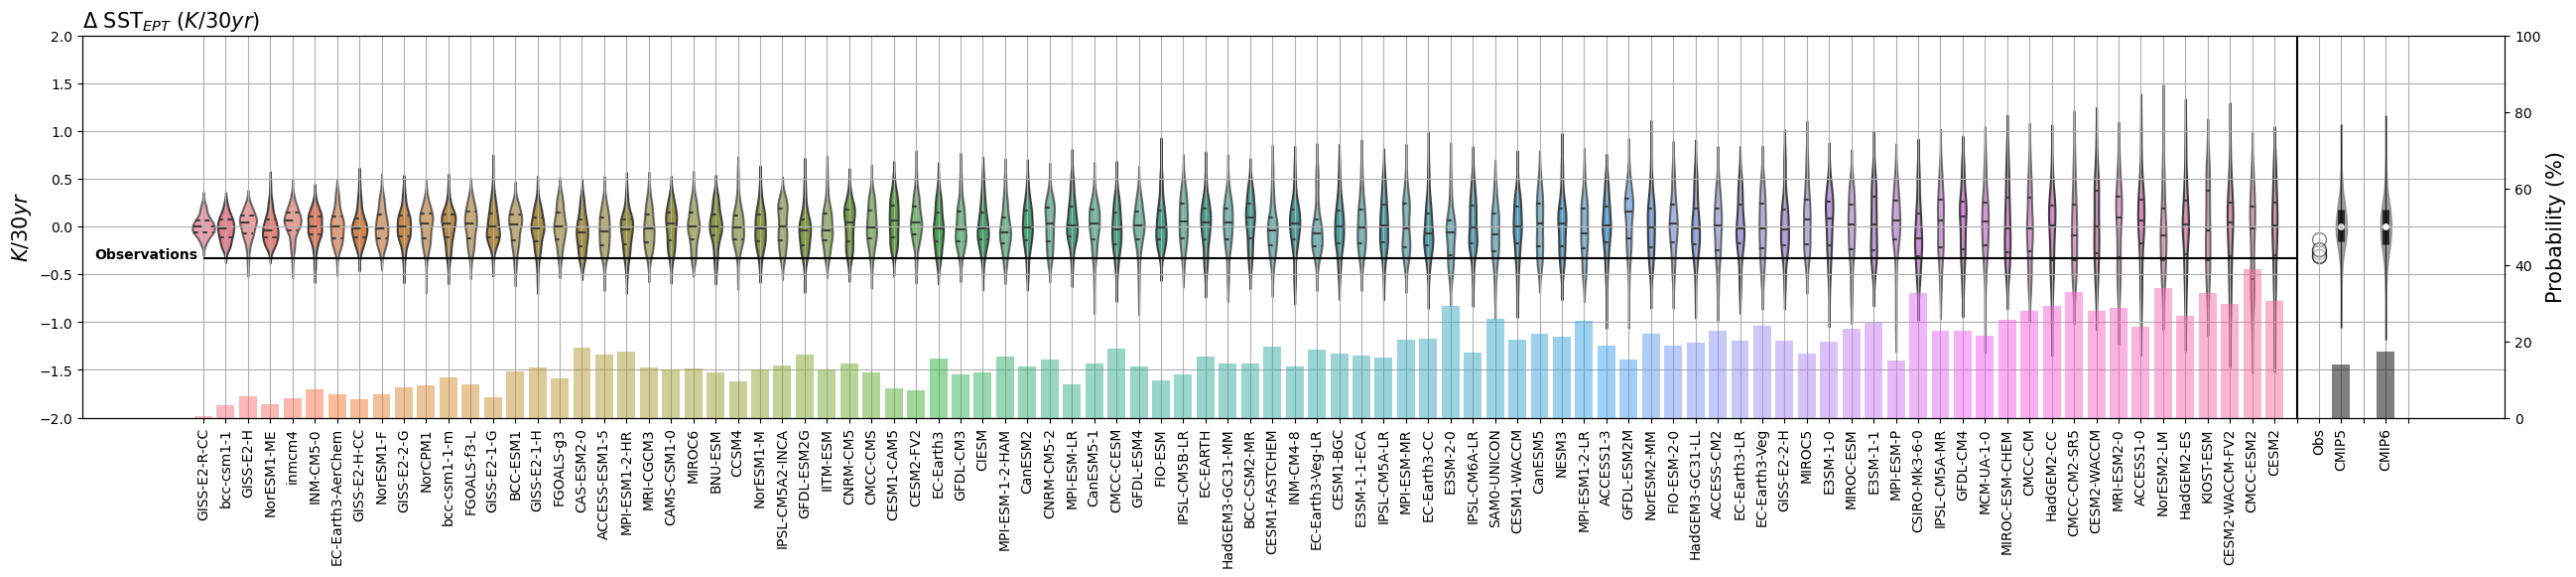

In [6]:
def create_violin_figure(tos_trends, tos_cmip5, tos_cmip6):
    # Choose a value for which you want to estimate the likelihood
    value_to_estimate = np.mean([-0.30995762, -0.30437485, -0.24953692, -0.26466877, -0.30762401, -0.13590471, -0.24306433])

    # CMIP5 and CMIP6 Means
    kde = gaussian_kde(tos_cmip5.values.flatten())
    likelihood_cmip5 = kde.integrate_box_1d(-np.inf, value_to_estimate)*100

    kde = gaussian_kde(tos_cmip6.values.flatten())
    likelihood_cmip6 = kde.integrate_box_1d(-np.inf, value_to_estimate)*100
    
    tos_trends = tos_trends.sortby(tos_trends.std("time"))

    # Estimate the KDE
    likelihoods = []
    for model in tos_trends.model.values:
        kde = gaussian_kde(tos_trends.sel(model=model))
        # Estimate the likelihood (probability density) for the chosen value
        likelihood = kde.integrate_box_1d(-np.inf, value_to_estimate)
        likelihoods.append(likelihood)
    likelihoods = np.array(likelihoods)*100

    nmodels = len(tos_trends.model.values)
    halfmodels = int(nmodels/2) + 1
    twoThirdsmodels = nmodels 

    default_palette = sns.color_palette("husl", nmodels)

    # violin_plot_tos_updated(
    #     tos_trends[:halfmodels].to_pandas().T, 
    #     title=r"$\Delta$ SST$_{East Pacific Cold Tongue}$ $(K/30yr)$", 
    #     Models=tos_trends[:halfmodels].model.values, 
    #     prob=likelihoods[:halfmodels], 
    #     colors=default_palette[:halfmodels], 
    #     letter="A", 
    #     save_name="Figure_1_bottom", 
    #     likelihood_cmip5=likelihood_cmip5, 
    #     likelihood_cmip6=likelihood_cmip6,
    #     tos_cmip5=tos_cmip5.values.flatten(),
    #     tos_cmip6=tos_cmip6.values.flatten()
    # )
    
    # violin_plot_tos_updated(
    #     tos_trends[halfmodels:twoThirdsmodels].to_pandas().T, 
    #     title=r"$\Delta$ SST$_{East Pacific Cold Tongue}$ $(K/30yr)$", 
    #     Models=tos_trends[halfmodels:twoThirdsmodels].model.values, 
    #     prob=likelihoods[halfmodels:twoThirdsmodels], 
    #     colors=default_palette[halfmodels:twoThirdsmodels], 
    #     letter="B", 
    #     save_name="Figure_1_top",
    #     likelihood_cmip5=likelihood_cmip5, 
    #     likelihood_cmip6=likelihood_cmip6,
    #     tos_cmip5=tos_cmip5.values.flatten(),
    #     tos_cmip6=tos_cmip6.values.flatten()
    # )

    violin_plot_tos_updated(
        tos_trends.to_pandas().T, 
        title=r"$\Delta$ SST$_{EPT}$ $(K/30yr)$", 
        Models=tos_trends.model.values, 
        prob=likelihoods, 
        colors=default_palette, 
        letter="B", 
        save_name="Figure_1_all",
        likelihood_cmip5=likelihood_cmip5, 
        likelihood_cmip6=likelihood_cmip6,
        tos_cmip5=tos_cmip5.values.flatten(),
        tos_cmip6=tos_cmip6.values.flatten()
    )


tos_trends = xr.concat([tos_regions_cmip5["eastPacificTriangle_trend"], tos_regions_cmip6["eastPacificTriangle_trend"]], dim="model")
create_violin_figure(tos_trends, tos_regions_cmip5["eastPacificTriangle_trend"], tos_regions_cmip6["eastPacificTriangle_trend"])

# Vertical

In [45]:
def style_violinplot(parts, data, ax, inds):
    for pc in parts['bodies']:
        pc.set_facecolor('gray')
        pc.set_edgecolor('gray')
        pc.set_alpha(.75)

    quartile1, medians, quartile3 = np.percentile(data, [25, 50, 75])
    whiskers_min = np.min(data)
    whiskers_max = np.max(data)
    print(whiskers_min, whiskers_max)

    # ax.scatter(inds, medians, marker='o', color='white', s=15, zorder=3)
    ax.scatter(medians, inds, marker='o', color='white', s=15, zorder=3)
    ax.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5, alpha=.75)
    ax.hlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1, alpha=.75)


def hor_violin_plot_tos_updated(tos, title, Models, prob, letter, colors, save_name, likelihood_cmip5, likelihood_cmip6, tos_cmip5, tos_cmip6):
    nums = np.arange(len(Models), dtype=int)
    fig = plt.figure()
    fig.set_size_inches(10, 35)

    ##### VIOLIN PLOT ######
    ax = sns.violinplot(data=tos, inner="quartiles", width=1.0, legend=True, palette=colors, orient="h") 

    parts5 = ax.violinplot(tos_cmip5, positions=[len(Models) + 2], showmeans=False, showmedians=False, showextrema=False, vert=False) 
    parts6 = ax.violinplot(tos_cmip6, positions=[len(Models) + 4], showmeans=False, showmedians=False, showextrema=False, vert=False) 

    style_violinplot(parts5, tos_cmip5, ax=ax, inds=[len(Models) + 2])
    style_violinplot(parts6, tos_cmip6, ax=ax, inds=[len(Models) + 4])
    
    for i, violin in enumerate(ax.collections[::2]):
        if i >= len(Models): break
        Num = nums[i]
        Model = Models[i]
        violin.set_alpha(.75)
        violin.set_label(f"{Num}: {Model}")
    
    # Add dots for each observational product 
    ax.scatter([-0.30995762, -0.30437485, -0.24953692, -0.26466877, -0.30762401, -0.13590471, -0.24306433], [len(Models)+1]*7, edgecolor="black", color="white", s=100, alpha=.5)

    #### BAR PLOT #####
    ax_bar = ax.twiny()

    ax_bar.barh(Models, prob, color=colors, alpha=.50)
    ax_bar.set_xlim(0, 100)
    ax_bar.set_xlabel("Probability (%)", fontsize=15)
    
    # # Add bar plots    
    ax_bar.barh(len(Models) + 2, likelihood_cmip5, color="black", alpha=.5)
    ax_bar.barh(len(Models) + 4, likelihood_cmip6, color="black", alpha=.5)

    
    # ##### STYLE PLOT #####
    # # Add obervations horizontal line
    ax.text(s="Observations", y=-.5, x=-.33, color="black", fontsize=10, fontweight="bold", horizontalalignment="right")
    ax.vlines([np.mean([-.33])], ymin=0, ymax=len(Models), color="black")
    # # Add a legend
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    # ax.set_title(title , loc="left", fontsize=15)
    ax.text(s=title, x=-2, y=-8, fontsize=18)
    ax.hlines(y=len(Models), xmin=-2.0, xmax=2.0, color="black")
    ax.grid()
    ax.set_xlim(-2.0, 2.0)
    # ax.margins(x=0.05, y=0.1) 
    # # Set labels and ticks
    ax.set_yticks(np.arange(len(Models) + 6))
    ax.set_yticklabels([*ax.get_yticklabels()[:len(Models)], "", "Obs", "CMIP5", "", "CMIP6", ""])
    ax.set_ylabel("")
    ax.set_xlabel(r"$K/30yr$", fontsize=15)
    # Save figure
    plt.savefig(f"{save_name}_hor.png", dpi=1200, bbox_inches="tight")

-1.0571299711323943 1.0661727591512966
-1.1868134487249673 1.16148528033192


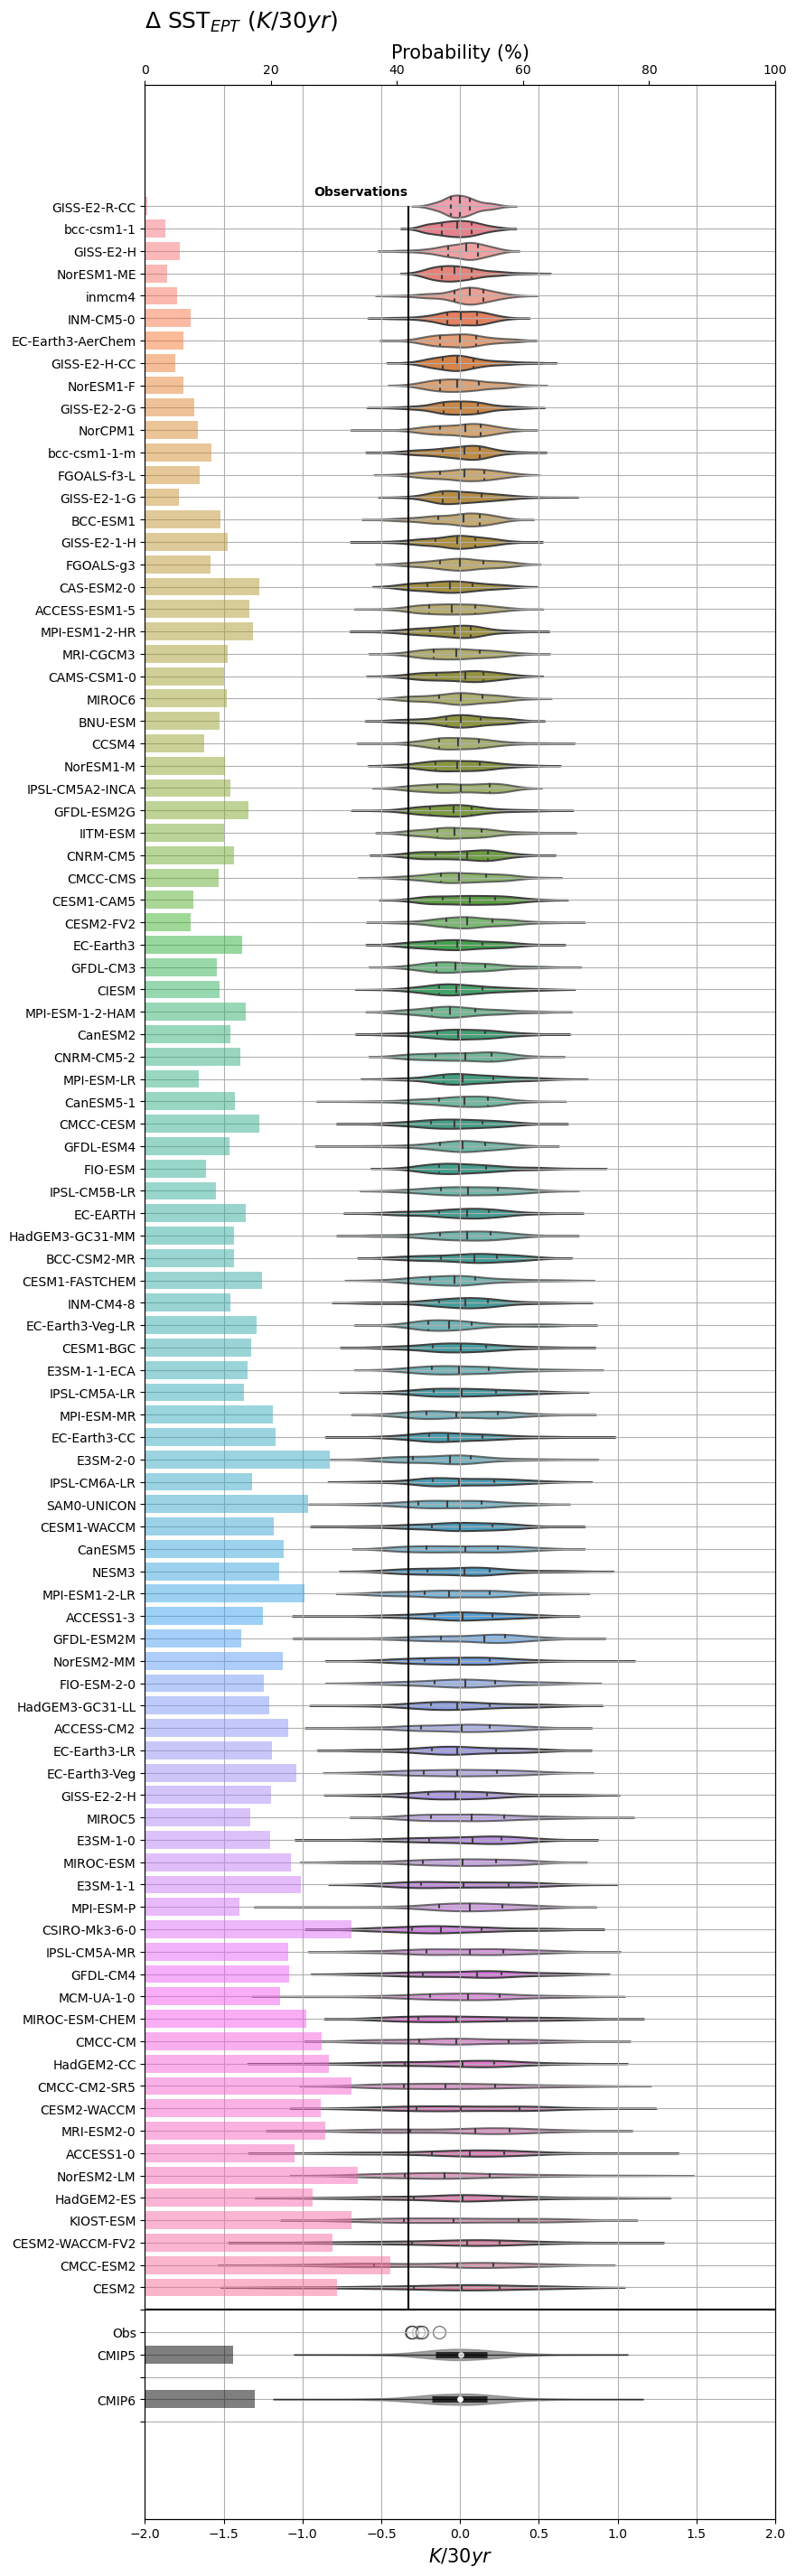

In [46]:
def create_horizontal_violin_figure(tos_trends, tos_cmip5, tos_cmip6):
    # Choose a value for which you want to estimate the likelihood
    value_to_estimate = np.mean([-0.30995762, -0.30437485, -0.24953692, -0.26466877, -0.30762401, -0.13590471, -0.24306433])

    # CMIP5 and CMIP6 Means
    kde = gaussian_kde(tos_cmip5.values.flatten())
    likelihood_cmip5 = kde.integrate_box_1d(-np.inf, value_to_estimate)*100

    kde = gaussian_kde(tos_cmip6.values.flatten())
    likelihood_cmip6 = kde.integrate_box_1d(-np.inf, value_to_estimate)*100
    
    tos_trends = tos_trends.sortby(tos_trends.std("time"))

    # Estimate the KDE
    likelihoods = []
    for model in tos_trends.model.values:
        kde = gaussian_kde(tos_trends.sel(model=model))
        # Estimate the likelihood (probability density) for the chosen value
        likelihood = kde.integrate_box_1d(-np.inf, value_to_estimate)
        likelihoods.append(likelihood)
    likelihoods = np.array(likelihoods)*100

    nmodels = len(tos_trends.model.values)
    halfmodels = int(nmodels/2) + 1
    twoThirdsmodels = nmodels 

    default_palette = sns.color_palette("husl", nmodels)

    hor_violin_plot_tos_updated(
        tos_trends.to_pandas().T, 
        title=r"$\Delta$ SST$_{EPT}$ $(K/30yr)$", 
        Models=tos_trends.model.values, 
        prob=likelihoods, 
        colors=default_palette, 
        letter="B", 
        save_name="Figure_1_all",
        likelihood_cmip5=likelihood_cmip5, 
        likelihood_cmip6=likelihood_cmip6,
        tos_cmip5=tos_cmip5.values.flatten(),
        tos_cmip6=tos_cmip6.values.flatten()
    )


tos_trends = xr.concat([tos_regions_cmip5["eastPacificTriangle_trend"], tos_regions_cmip6["eastPacificTriangle_trend"]], dim="model")
create_horizontal_violin_figure(tos_trends, tos_regions_cmip5["eastPacificTriangle_trend"], tos_regions_cmip6["eastPacificTriangle_trend"])

# Figure SX - WE-SST Gradient vs. EPT 

In [10]:
# we_trend_5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_Wills-WE-Trend.nc")
# we_trend_5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_WE-Trend-Wills.nc")
ept_t_5 = xr.open_dataarray("data/piControl/rolling_gradient_cmip5_eastPacificTriangle_trend.nc")
cod_5 = xscore.pearson_r(we_trend_5, ept_t_5, dim="time")**2

# we_trend_6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_Wills-WE-Trend.nc")
# we_trend_6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_WE-Trend-Wills.nc")
# ept_t_6 = xr.open_dataarray("data/piControl/rolling_gradient_cmip6_eastPacificTriangle_trend.nc")
# cod_6 = xscore.pearson_r(we_trend_6, ept_t_6, dim="time")**2
# print(cod_6.mean())
print(cod_5.mean())

<xarray.DataArray ()>
array(0.48258653)


<BarContainer object of 54 artists>

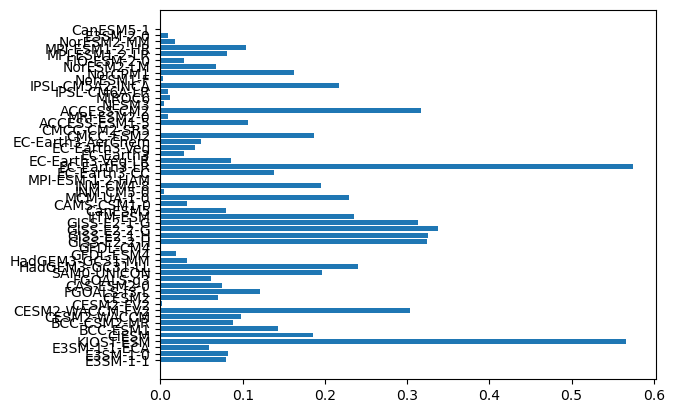

In [6]:
plt.barh(cod_6.model, cod_6)

# def ver_we_ept(tos, title, Models, prob, letter, colors, save_name, likelihood_cmip5, likelihood_cmip6, tos_cmip5, tos_cmip6):
#     nums = np.arange(len(Models), dtype=int)
#     fig = plt.figure()
#     fig.set_size_inches(10, 35)

    # #### BAR PLOT #####
    # ax_bar.barh(Models, prob, color=colors, alpha=.50)
    # ax_bar.set_xlim(0, 100)
    # ax_bar.set_xlabel("Probability (%)", fontsize=15)
    
    # # # Add bar plots    
    # ax_bar.barh(len(Models) + 2, likelihood_cmip5, color="black", alpha=.5)
    # ax_bar.barh(len(Models) + 4, likelihood_cmip6, color="black", alpha=.5)

    
    # # ##### STYLE PLOT #####
    # # # Add obervations horizontal line
    # ax.text(s="Observations", y=-.5, x=-.33, color="black", fontsize=10, fontweight="bold", horizontalalignment="right")
    # # # Add a legend
    # pos = ax.get_position()
    # ax.set_position([pos.x0, pos.y0, pos.width * 0.9, pos.height])
    # # ax.set_title(title , loc="left", fontsize=15)
    # ax.text(s=title, x=-2, y=-8, fontsize=18)
    # ax.hlines(y=len(Models), xmin=-2.0, xmax=2.0, color="black")
    # ax.grid()
    # ax.set_xlim(-2.0, 2.0)
    # # # Set labels and ticks
    # ax.set_yticks(np.arange(len(Models) + 6))
    # ax.set_yticklabels([*ax.get_yticklabels()[:len(Models)], "", "Obs", "CMIP5", "", "CMIP6", ""])
    # ax.set_ylabel("")
    # ax.set_xlabel(r"$K/30yr$", fontsize=15)
    # # Save figure
    # plt.savefig(f"{save_name}_hor.png", dpi=1200, bbox_inches="tight")